In [1]:
import numpy as np
import pickle
from MeanReversionAlg import MeanReversionTrader  # your module
import matplotlib.pyplot as plt
import pandas as pd


In [2]:

def loadPrices(fn):
    global nt, nInst
    df=pd.read_csv(fn, sep=r'\s+', header=None, index_col=None)
    (nt,nInst) = df.shape
    return (df.values).T

pricesFile="prices.txt"
prcAll = loadPrices(pricesFile)

prcTrain = prcAll[:, :450]
prcTestOnly= prcAll[:, 450:600]
prcTest= prcAll[:, :600]
prcValOnly= prcAll[:, 600:]
prcVal= prcAll[:, :]

In [3]:

with open("market_condition/mean_reversion_params.pkl", "rb") as f:
    data = pickle.load(f)

beta_matrix = data["beta_matrix"]
alpha_matrix = data["alpha_matrix"]
pairs = data["pairs"]
if __name__ == "__main__":
    print(pairs)

[(1, 49), (3, 12), (6, 23), (7, 35), (8, 34), (8, 40), (8, 44), (15, 37), (15, 48), (20, 35), (25, 48), (25, 49), (37, 48), (37, 49), (48, 49)]


-9477.93 9252.16
-9493.36 8666.560000000001
-9498.3 8351.7
-9482.55 8919.24
-9488.8 8966.8
-8841.74 9418.32
-9356.16 9431.4
-9489.24 9209.31
-9466.8 8782.2
-9479.4 8637.6
-9492.21 8714.72
    Day  Asset A  Asset B       Action   Z-Score  Return
0    29        8       40   Enter Long -2.325910    None
1    38        8       40         Exit -0.438832   1.86%
2    74        8       40   Enter Long -2.672658    None
3    87        8       40         Exit -0.447174   0.22%
4    94        8       40  Enter Short  2.244083    None
5   104        8       40         Exit  0.455922   1.84%
6   117        8       40  Enter Short  2.386576    None
7   123        8       40         Exit  0.449095   2.46%
8   138        8       40  Enter Short  2.179153    None
9   142        8       40         Exit -0.055764   3.29%
10  172        8       40  Enter Short  2.045002    None
11  177        8       40         Exit  0.240468   1.39%
12  184        8       40   Enter Long -2.574605    None
13  197       

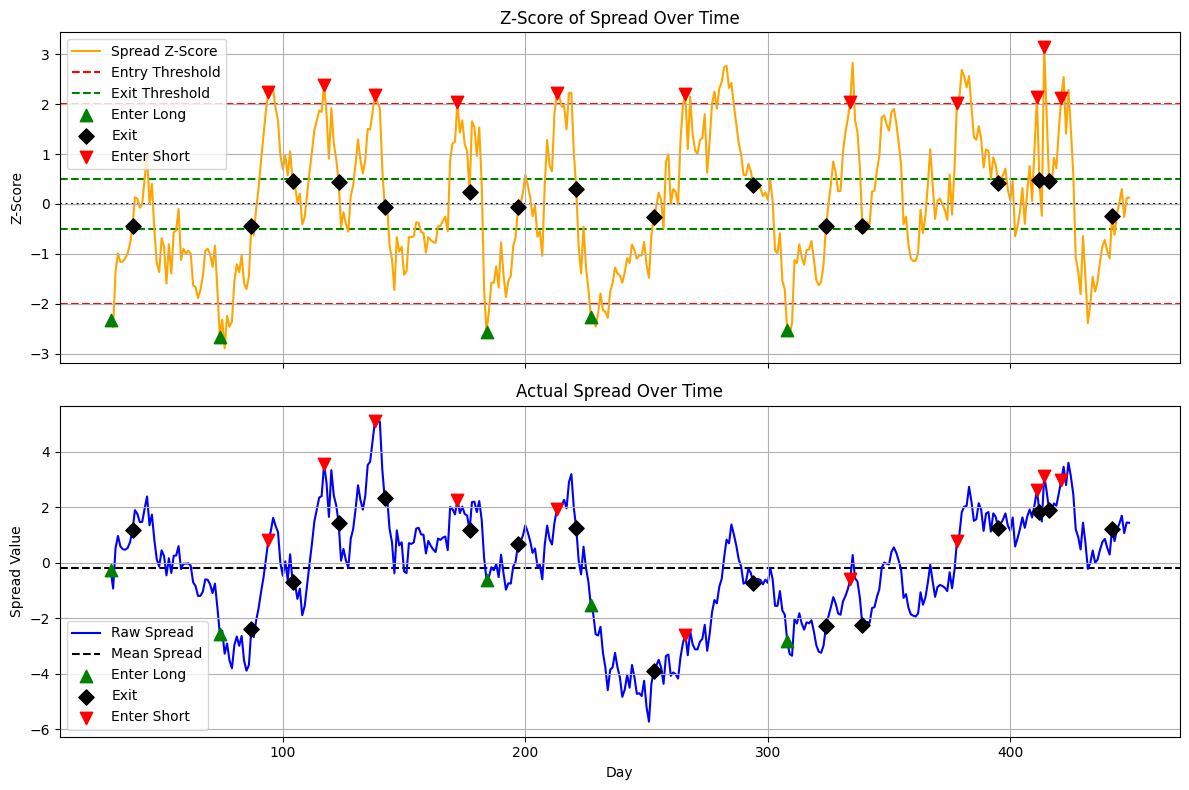

In [ ]:
# --- Step 3: Run trader with ONE pair for now ---
num = 5
trader = MeanReversionTrader(pairs=[pairs[num]], beta_matrix=beta_matrix, alpha_matrix=alpha_matrix)

# Run simulation
trader.run(prcTrain)

# --- Step 4: Analyze Results ---
# Show trade log
log = trader.get_trade_log()
print(log)

# Plot the spread z-score evolution
# trader.plot_spread()
trader.plot_spread()

In [5]:
completed_trades = log[log["Action"] == "Exit"].copy()

# Clean the Return column if it’s a string with "%"
completed_trades["Return"] = completed_trades["Return"].str.replace('%', '').astype(float)

# Compute mean return %
mean_return = completed_trades["Return"].mean()

print(f"Mean Return per Trade: {mean_return:.2f}%")


Mean Return per Trade: 0.96%


In [6]:
completed_trades = log[log["Action"] == "Exit"].copy()

# Clean if stored as percentage strings (optional safeguard)
if completed_trades["Return"].dtype == object:
    completed_trades["Return"] = completed_trades["Return"].str.replace('%', '').astype(float)

total_trades = len(completed_trades)
wins = (completed_trades["Return"] > 0).sum()
win_rate = wins / total_trades if total_trades > 0 else np.nan

print(f"Total Trades: {total_trades}")
print(f"Wins: {wins}")
print(f"Win Rate: {win_rate:.2%}")

Total Trades: 16
Wins: 13
Win Rate: 81.25%


In [7]:
def compute_trade_durations(log):
    """
    Computes duration stats of completed trades from the log.

    Returns:
        - durations (list of int)
        - mean duration
        - std deviation of duration
    """
    entries = log[log["Action"].str.startswith("Enter")].copy()
    exits = log[log["Action"] == "Exit"].copy()

    durations = []

    # Match entry and exit by asset pair
    for _, entry_row in entries.iterrows():
        day_entry = entry_row["Day"]
        a, b = entry_row["Asset A"], entry_row["Asset B"]

        # Find the first matching exit after this entry
        exit_match = exits[(exits["Asset A"] == a) & (exits["Asset B"] == b) & (exits["Day"] > day_entry)]
        if not exit_match.empty:
            day_exit = exit_match.iloc[0]["Day"]
            durations.append(day_exit - day_entry)

    if durations:
        durations = np.array(durations)
        mean_duration = durations.mean()
        std_duration = durations.std()
        print(f"Mean Trade Duration: {mean_duration:.2f} days")
        print(f"Std Dev of Trade Duration: {std_duration:.2f} days")
    else:
        mean_duration = std_duration = np.nan
        print("No completed trades to compute durations.")

    return durations, mean_duration, std_duration
durations, mean_duration, std_duration = compute_trade_durations(log)

Mean Trade Duration: 11.50 days
Std Dev of Trade Duration: 7.98 days
